# Customer Revenue Prediction

#### Problem Statement
In every business it was proven about 80/20 rule, this rule tells us 80% of our revenue will be generated by only 20% of our potential customers. So our goal is to predict the total revenue per customer that helps marketing teams in better use of marketing budget to attract potential customers and we will also interpret the most impacting element on the total revenue.

### Data Mining

Loading Google Merchandise Store customer dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import collections
from sklearn.preprocessing import LabelEncoder
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
import lightgbm as lgbm
import gc
gc.enable()

In [3]:
train = pd.read_csv('E:/College/Analytics/Python/GA-Revenue/train_v2.csv')

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Exploration

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 13 columns):
channelGrouping         object
customDimensions        object
date                    int64
device                  object
fullVisitorId           object
geoNetwork              object
hits                    object
socialEngagementType    object
totals                  object
trafficSource           object
visitId                 int64
visitNumber             int64
visitStartTime          int64
dtypes: int64(4), object(9)
memory usage: 169.4+ MB


In [5]:
train.shape

(1708337, 13)

In [10]:
train.head(3)

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",3162355547410993243,"{""continent"": ""Europe"", ""subContinent"": ""Weste...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1508198450,1,1508198450
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8934116514970143966,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/a/google.com/transportation...",1508176307,6,1508176307
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",7992466427990357681,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1508201613,1,1508201613


In [7]:
train.isnull().sum().sort_values(ascending=False)

visitStartTime          0
visitNumber             0
visitId                 0
trafficSource           0
totals                  0
socialEngagementType    0
hits                    0
geoNetwork              0
fullVisitorId           0
device                  0
date                    0
customDimensions        0
channelGrouping         0
dtype: int64

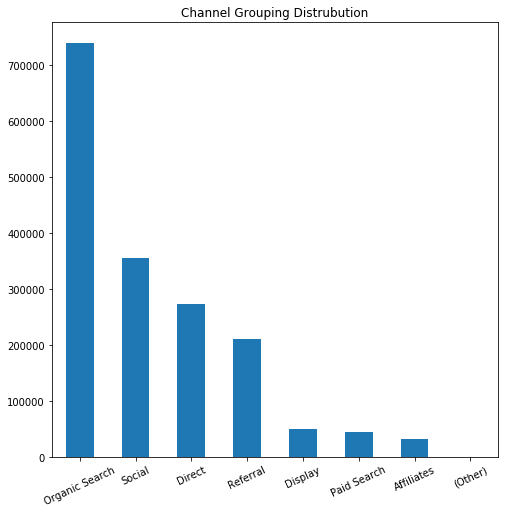

In [8]:
train['channelGrouping'].value_counts().plot(kind="bar",title="Channel Grouping Distrubution",figsize=(8,8),rot=25)

(array([1.30743e+06, 2.53504e+05, 7.69020e+04, 3.49070e+04, 1.81220e+04,
        8.36800e+03, 4.26100e+03, 2.85300e+03, 1.48400e+03, 5.06000e+02]),
 array([0.        , 0.61246834, 1.22493668, 1.83740502, 2.44987336,
        3.0623417 , 3.67481003, 4.28727837, 4.89974671, 5.51221505,
        6.12468339]),
 <a list of 10 Patch objects>)

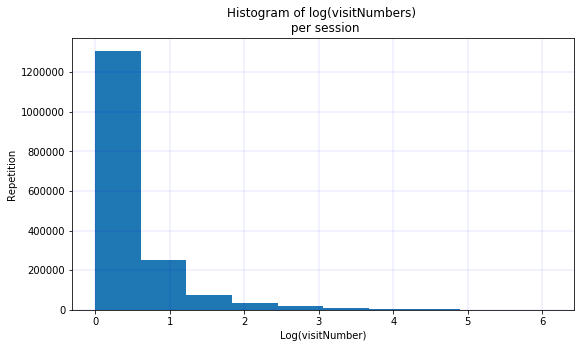

In [29]:
fig,ax = plt.subplots(figsize=(9,5))
ax.set_title("Histogram of log(visitNumbers) \n per session")
ax.set_ylabel("Repetition")
ax.set_xlabel("Log(visitNumber)")
ax.grid(color='b', linestyle='-', linewidth=0.1)
ax.hist(np.log(train['visitNumber']))

In [12]:
train['socialEngagementType'].value_counts()

Not Socially Engaged    1708337
Name: socialEngagementType, dtype: int64

In [13]:
train.head(1)[["date","visitStartTime"]]

,date,visitStartTime
0,20171016,1508198450


### Data Cleaning

Observed that there are four JSON features in the train datasets namely 'device', 'geoNetwork', 'totals', 'trafficSource. These features need to be flattened out

In [14]:
train["date"]=pd.to_datetime(train["date"],format="%Y%m%d")

In [15]:
list_of_devices = train['device'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in device attribute are:{}".format(keys)

"keys existed in device attribute are:['browser', 'browserVersion', 'browserSize', 'operatingSystem', 'operatingSystemVersion', 'isMobile', 'mobileDeviceBranding', 'mobileDeviceModel', 'mobileInputSelector', 'mobileDeviceInfo', 'mobileDeviceMarketingName', 'flashVersion', 'language', 'screenColors', 'screenResolution', 'deviceCategory']"

In [16]:
device_df = pd.DataFrame(train.device.apply(json.loads).tolist())[["browser","operatingSystem","deviceCategory","isMobile"]]
device_df.head(5)

,browser,operatingSystem,deviceCategory,isMobile
0,Firefox,Windows,desktop,False
1,Chrome,Chrome OS,desktop,False
2,Chrome,Android,mobile,True
3,Chrome,Windows,desktop,False
4,Chrome,Windows,desktop,False


In [17]:
list_of_devices = train['trafficSource'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in trafficSource attribute are:{}".format(keys)

"keys existed in trafficSource attribute are:['campaign', 'source', 'medium', 'keyword', 'adwordsClickInfo', 'referralPath', 'isTrueDirect', 'adContent', 'campaignCode']"

In [18]:
traffic_source_df = pd.DataFrame(train.trafficSource.apply(json.loads).tolist())[["keyword","medium","source","adContent"]]
traffic_source_df.head(5)

,keyword,medium,source,adContent
0,water bottle,organic,google,NaN
1,NaN,referral,sites.google.com,NaN
2,NaN,(none),(direct),NaN
3,(not provided),organic,google,NaN
4,(not provided),organic,google,NaN


In [19]:
list_of_devices = train['geoNetwork'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in geoNetwork attribute are:{}".format(keys)

"keys existed in geoNetwork attribute are:['continent', 'subContinent', 'country', 'region', 'metro', 'city', 'cityId', 'networkDomain', 'latitude', 'longitude', 'networkLocation']"

In [20]:
geo_df = pd.DataFrame(train.geoNetwork.apply(json.loads).tolist())[["continent","subContinent","country","city"]]
geo_df.head(5)

,continent,subContinent,country,city
0,Europe,Western Europe,Germany,not available in demo dataset
1,Americas,Northern America,United States,Cupertino
2,Americas,Northern America,United States,not available in demo dataset
3,Asia,Western Asia,Turkey,not available in demo dataset
4,Americas,Central America,Mexico,not available in demo dataset


In [21]:
list_of_devices = train['totals'].apply(json.loads).tolist()
keys = []
for devices_iter in list_of_devices:
    for list_element in list(devices_iter.keys()):
        if list_element not in keys:
            keys.append(list_element)
            
"keys existed in totals attribute are:{}".format(keys)

"keys existed in totals attribute are:['visits', 'hits', 'pageviews', 'bounces', 'newVisits', 'sessionQualityDim', 'timeOnSite', 'transactions', 'transactionRevenue', 'totalTransactionRevenue']"

In [22]:
totals_df = pd.DataFrame(train.totals.apply(json.loads).tolist())[[ "pageviews", "hits","transactionRevenue", "newVisits", "bounces"]]
totals_df.head(5)

,pageviews,hits,transactionRevenue,newVisits,bounces
0,1,1,NaN,1,1
1,2,2,NaN,NaN,NaN
2,2,2,NaN,1,NaN
3,2,2,NaN,1,NaN
4,2,2,NaN,1,NaN


In [39]:
df_train=pd.concat([train.drop(["hits"],axis=1),device_df,geo_df,traffic_source_df,totals_df],axis=1)
df_train.dtypes

channelGrouping                 object
customDimensions                object
date                    datetime64[ns]
device                          object
fullVisitorId                   object
geoNetwork                      object
socialEngagementType            object
totals                          object
trafficSource                   object
visitId                          int64
visitNumber                      int64
visitStartTime                   int64
browser                         object
operatingSystem                 object
deviceCategory                  object
isMobile                          bool
continent                       object
subContinent                    object
country                         object
city                            object
keyword                         object
medium                          object
source                          object
adContent                       object
pageviews                       object
hits                     

In [40]:
df_train.isnull().sum().sort_values(ascending=False)

transactionRevenue      1689823
adContent               1643600
keyword                 1052780
bounces                  836759
newVisits                400907
pageviews                   239
customDimensions              0
date                          0
device                        0
visitStartTime                0
fullVisitorId                 0
geoNetwork                    0
socialEngagementType          0
totals                        0
trafficSource                 0
visitId                       0
visitNumber                   0
deviceCategory                0
browser                       0
operatingSystem               0
isMobile                      0
continent                     0
subContinent                  0
country                       0
city                          0
medium                        0
source                        0
hits                          0
channelGrouping               0
dtype: int64

In [41]:
df_train=df_train.fillna(0)

numerical_features = ['transactionRevenue','visitNumber', 'newVisits', 'bounces', 'pageviews', 'hits']

for col in numerical_features:
    df_train[col] = df_train[col].astype(np.float)

### Exploratory Data analysis

#### Most Common and Least Common Customers

In [42]:
tmp_least_visitNumbers_list = collections.Counter(list(df_train.visitNumber)).most_common()[:-10-1:-1]
tmp_most_visitNumbers_list = collections.Counter(list(df_train.visitNumber)).most_common(10)
least_visitNumbers = []
most_visitNumbers = []
for i in tmp_least_visitNumbers_list:
    least_visitNumbers.append(i[0])
for i in tmp_most_visitNumbers_list:
    most_visitNumbers.append(i[0])
"10 most_common visitNumbers are {} times and 10 least_common visitNumbers are {} times".format(most_visitNumbers,least_visitNumbers)

'10 most_common visitNumbers are [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0] times and 10 least_common visitNumbers are [446.0, 451.0, 382.0, 409.0, 426.0, 427.0, 376.0, 377.0, 406.0, 444.0] times'

#### Target feature analysis

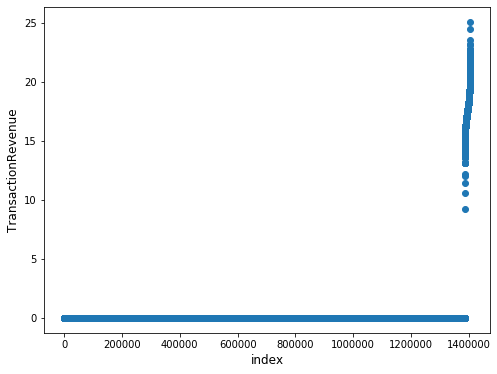

It is clear by looking at this graph that most of the transactions had generated zero revenue but only few transactions had no-zero revenue, as stated by the 80/20 rule


In [52]:
gdf = df_train.groupby("fullVisitorId")["transactionRevenue"].sum().reset_index()
plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()
print("It is clear by looking at this graph that most of the transactions had generated zero revenue but only few transactions had no-zero revenue, as stated by the 80/20 rule")

In [53]:
num_buyers = (gdf["transactionRevenue"]>0).sum()
print("Number of unique customers: ",gdf.shape[0]," with non-zero revenue : ", num_buyers, "and the ratio is : ", (num_buyers / gdf.shape[0])*100)
print ("The ratio is much lower than 80/20, only 1.21% of visitors have spent money")

Number of unique customers:  1404686  with non-zero revenue :  16992 and the ratio is :  1.2096653629352039
The ratio is much lower than 80/20, only 1.21% of visitors have spent money


### Visitor Profile
Lets create the visitor profile by aggregating the rows for every customer.

In [57]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["bounces", "hits", "newVisits", "pageviews", "transactionRevenue"]:
    df_train[col] = df_train[col].astype('float')
    agg_dict[col] = "sum"
tmp = df_train.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,bounces,hits,newVisits,pageviews,transactionRevenue
0,3038793126460,0.0,6.0,1.0,6.0,0.0
1,5103959234087,0.0,10.0,1.0,8.0,0.0
2,9663019041506,1.0,1.0,1.0,1.0,0.0
3,10278554503158,0.0,11.0,1.0,8.0,0.0
4,10438463470860,0.0,5.0,1.0,5.0,0.0


### Data Visualization

In [61]:
def feat_plot(col):
    pt = df_train.loc[:,[col, 'transactionRevenue']]
    feat_vis=pt.groupby(col)['transactionRevenue'].agg(['size','count','mean'])
    feat_vis.columns = ["count","count of non-zero revenue","mean transaction value"]
    feat_vis = feat_vis.sort_values(by="count", ascending=False)
    plt.figure(figsize=(8, 16)) 
    plt.subplot(3,1,1)
    sns.barplot(x=feat_vis['count'].head(10), y=feat_vis.index[:10])
    plt.subplot(3,1,2)
    sns.barplot(x=feat_vis['count of non-zero revenue'].head(10), y=feat_vis.index[:10])
    plt.subplot(3,1,3)
    sns.barplot(x=feat_vis['mean transaction value'].head(10), y=feat_vis.index[:10])

#### Web-browser analysis

We will see no.of visits and transactions that are happening through each web-browser

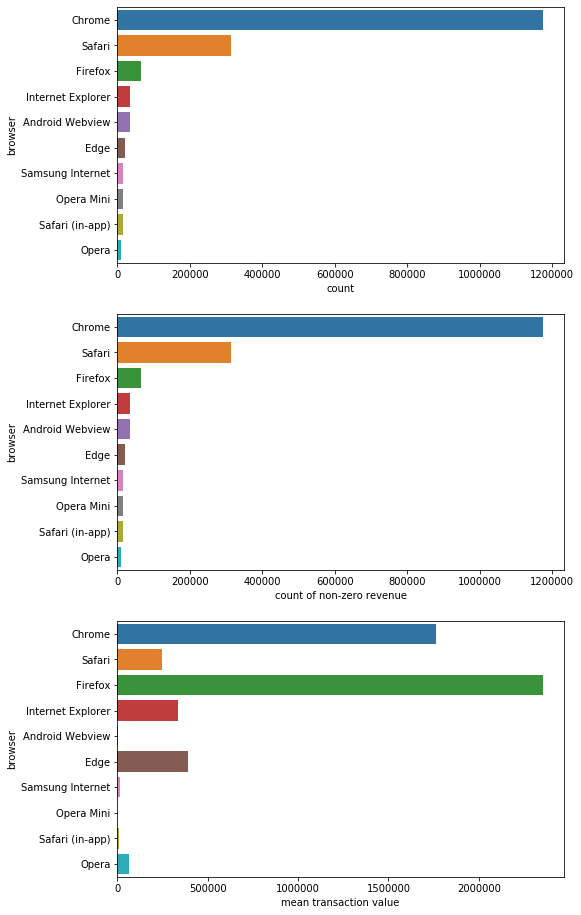

In [62]:
feat_plot('browser')

The no.of visits in chrome browser are very huge compare with all browsers.

The most revenue is coming from ‘Chrome’, ‘Firefox’,’safari’,’Internet explorer’,’edge’,’opera’,’Samsung internet’

So here conclusion is the analytics team can invest less money on the users visiting store through browsers(ex:safari,Firefox,opera,edge) except chrome and can generate most revenue.

#### Device category analysis

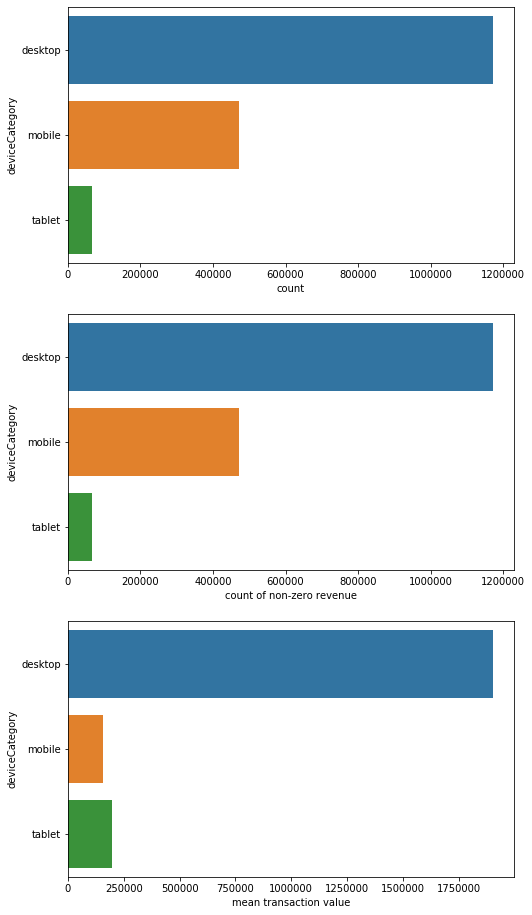

In [63]:
feat_plot('deviceCategory')

Most of the users are visiting through desktop. Here the very important observation is through tablet device less than 68K people(this is significantly less compare with other devices) are visiting but they are generating significantly higher revenue.

So analytics team can invest less amount of money for promotions on the users visiting store through ‘tablet device’ and can generate significantly higher revenue.

#### Operating System analysis

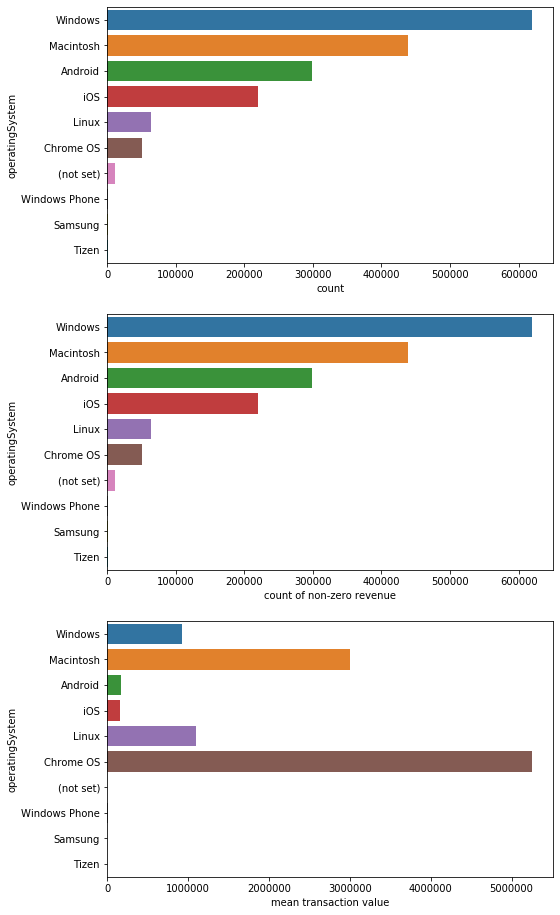

In [64]:
feat_plot('operatingSystem')

Most of the users are visiting store through Windows, Macintosh and the most revenue is generating from windows and Macintosh.

If we observe carefully very less people (less than 100K) are visiting through Linux and chrome OS., so business team can invest very less on money for promotions on this two OS platforms and can generate most revenue.

Very importantly through windows phone less than 2000 people are visiting merchandise site but they are also generating good amount of revenue. so analytics team can invest less money on the windows phone OS and can generate good revenue.

#### Channel grouping analysis

We will see no.of visits and transactions that are happening through each channel 

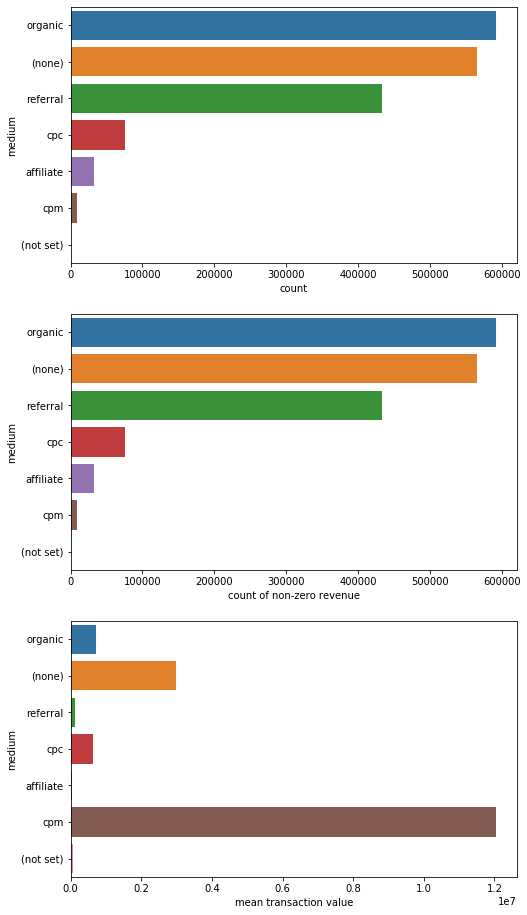

In [67]:
feat_plot('medium')

The most revenue is coming from 'cpm','Direct (none)',’Referral’, but no.of visits in 'Organic', 'cpm' are very less.

so here conclusion is the analytics team can invest less money in 'Direct','cpm' channels (since less users are visiting from this channel) and can generate most revenue.

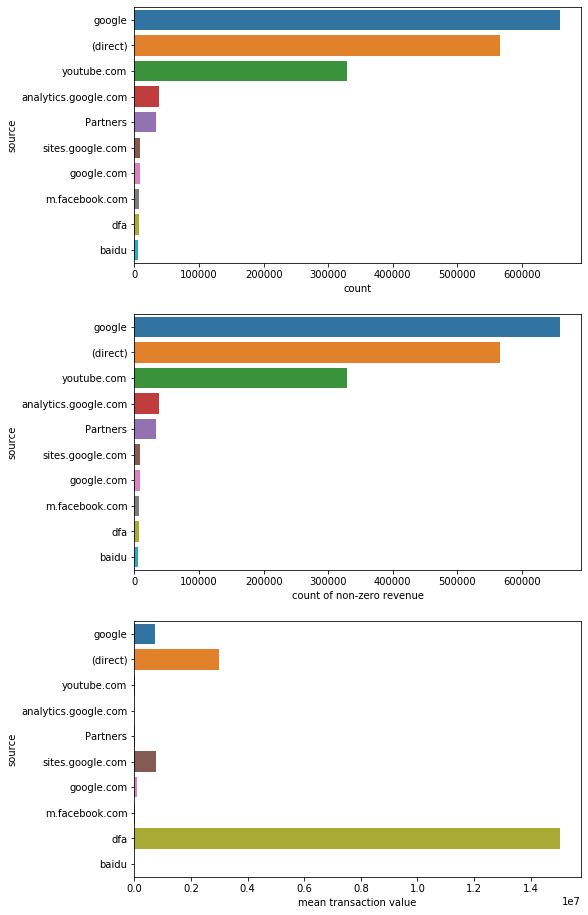

In [66]:
feat_plot('source')

Even though Youtube has high number of counts in the dataset, the number of non-zero revenue counts are very less

Google is the clear leader for traffic source but most transactions appear to be coming from within the googleplex.com domain, implying that many staff at Google are purchasing from the store

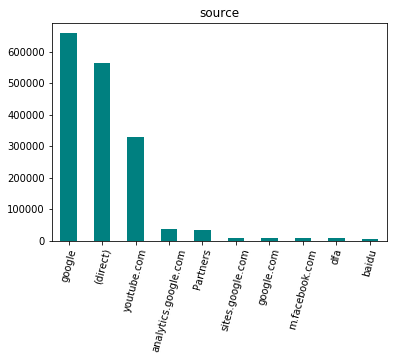

In [43]:
df_train["source"].value_counts().head(10).plot(kind="bar",title="source",rot=75,color="teal")

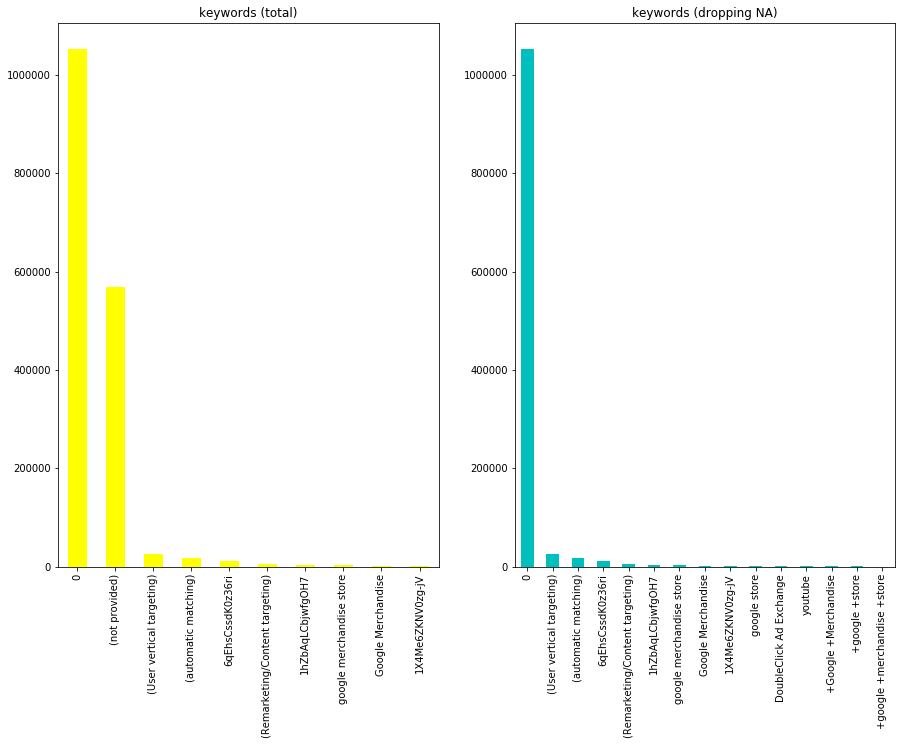

In [44]:
fig,axes = plt.subplots(1,2,figsize=(15,10))
df_train["keyword"].value_counts().head(10).plot(kind="bar",ax=axes[0], title="keywords (total)",color="yellow")
df_train[traffic_source_df["keyword"] != "(not provided)"]["keyword"].value_counts().head(15).plot(kind="bar",ax=axes[1],title="keywords (dropping NA)",color="c")

#### Continent analysis

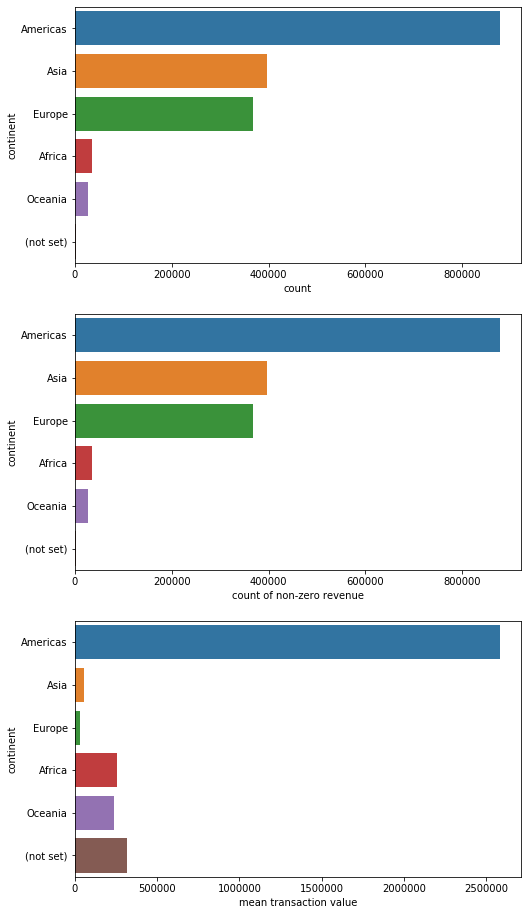

In [69]:
feat_plot('continent')

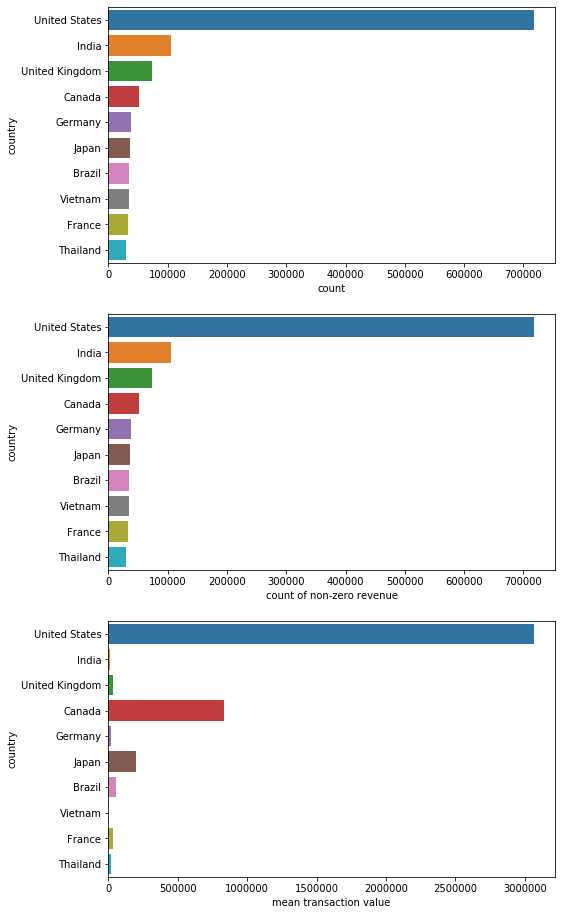

In [73]:
feat_plot('country')

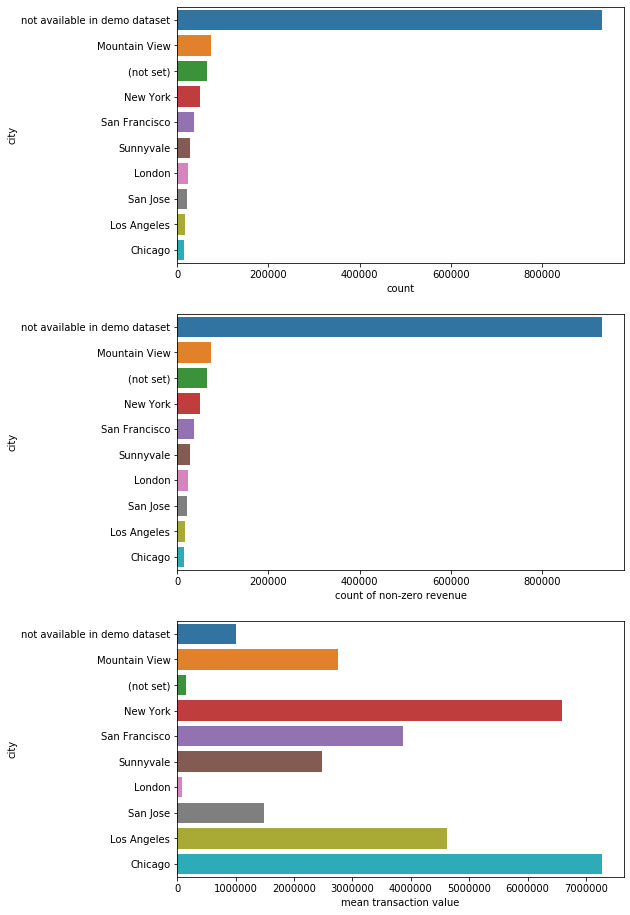

In [71]:
feat_plot('city')

No.of visits from Americas are significantly more compare with other continents. In particular the United States with states such as California, New York and Washington having higher numbers of buyers

Even no.of visits are less from 'Oceania','Africa', but this continents are also generating good amount of revenue. so its’s better to invest in this two continents sources

### Trend analysis

Now we will how no.of visits and transactions are happening over time

In [45]:
from datetime import datetime
df_train["month"] = df_train['date'].dt.month
df_train['visitHour'] = (df_train['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)

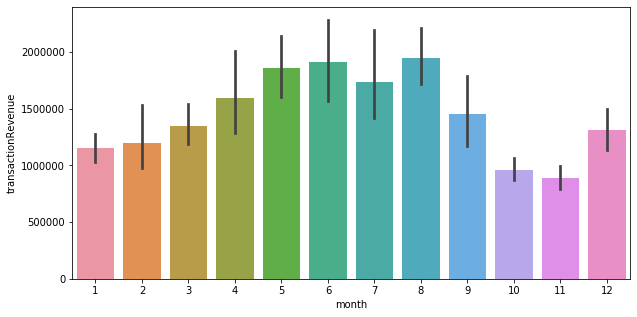

In [46]:
plt.figure(figsize=(10,5))
sns.barplot(x='month', y=df_train['transactionRevenue'].astype(np.float), data=df_train)

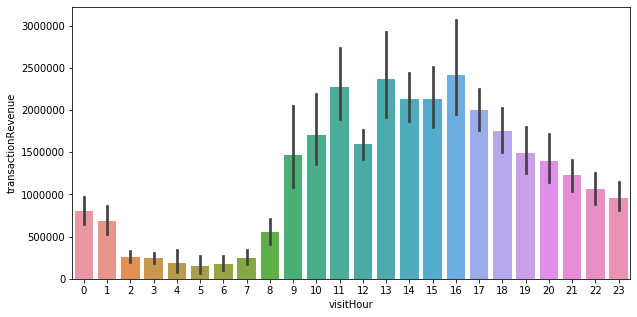

In [74]:
plt.figure(figsize=(10,5))
sns.barplot(x='visitHour', y=df_train['transactionRevenue'].astype(np.float), data=df_train)

From morning 9 am to night 11 pm ,revenue generation is high, After midnight to early time , revenue generation is very less

So analytics team can invest more money between 12-5 pm for more revenue generation

#### Date v/s transactionRevenue

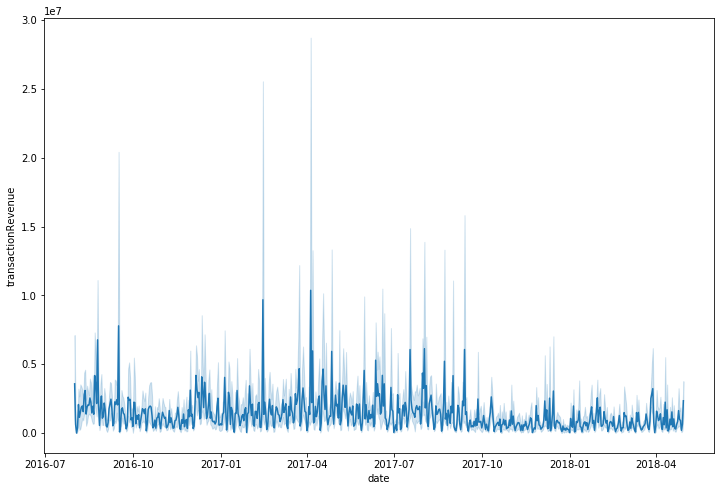

In [54]:
plt.figure(figsize=(12, 8))
#plt.style.use('fivethirtyeight')
sns.lineplot(df_train['date'], df_train['transactionRevenue'])

#### Date v/s userCounts

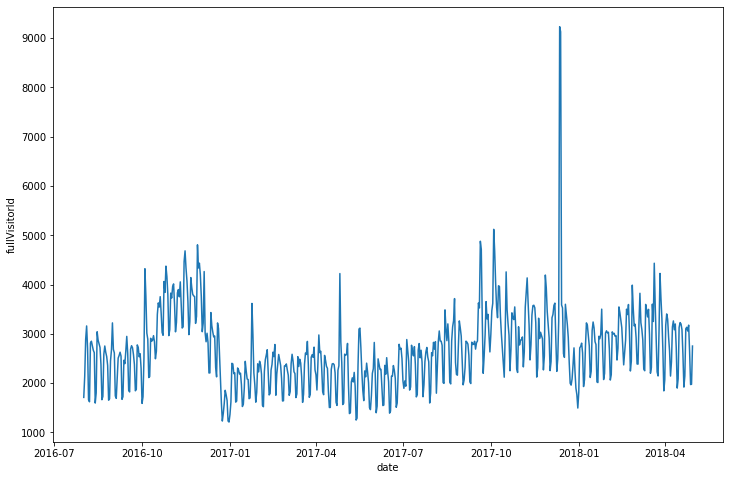

In [58]:
cnt_srs = df_train.groupby('date')['fullVisitorId'].size().reset_index()
plt.figure(figsize=(12, 8))
sns.lineplot(cnt_srs['date'], cnt_srs['fullVisitorId'])

If we observe the above plot in the month of December-2017 the the no.of visits and revenue are raised drastically.
so this one of the useful insights to the promotional team, so that they can invest more money in promotions in the month of December.

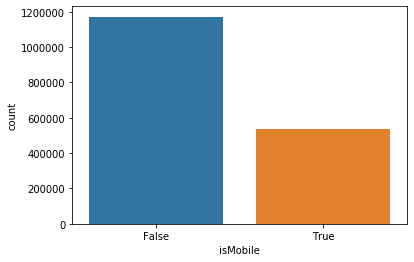

In [27]:
sns.countplot(df_train['isMobile'])

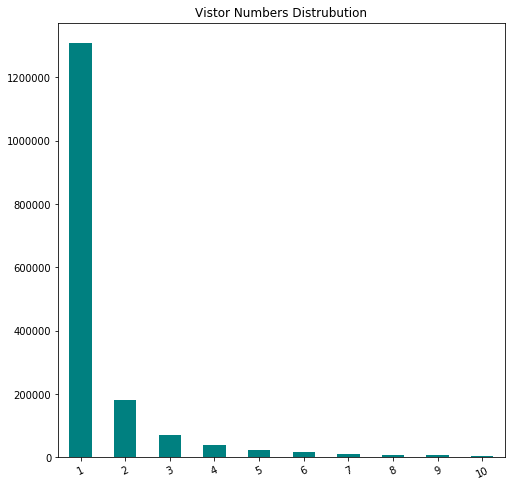

In [38]:
df_train.visitNumber.value_counts().head(10).plot(kind="bar",title="Vistor Numbers Distrubution",figsize=(8,8),rot=25,color='teal')

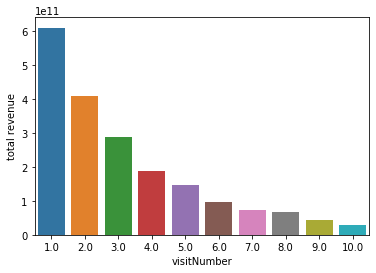

In [45]:
vst_rev=df_train.groupby('visitNumber')['transactionRevenue'].agg(['count','mean','sum'])
vst_rev.columns = ["count", "mean transaction","total revenue"]
vst_rev = vst_rev.sort_values(by="count", ascending=False)
sns.barplot(y=vst_rev['total revenue'].head(10),x=vst_rev.index[:10])

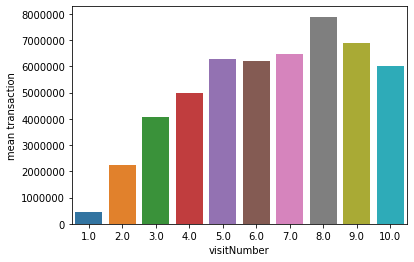

In [46]:
sns.barplot(y=vst_rev['mean transaction'].head(10),x=vst_rev.index[:10])

#### from which source users are visiting?

picture says everything

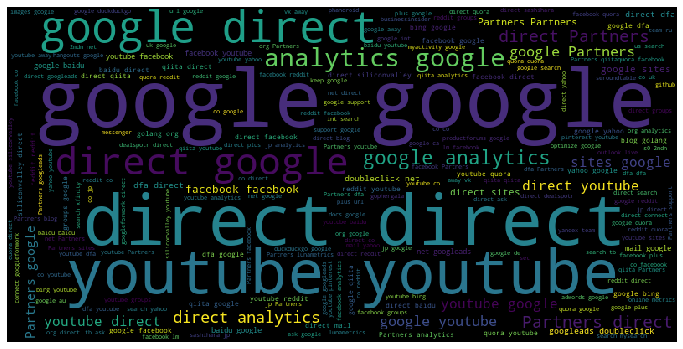

In [79]:
from wordcloud import WordCloud
source = df_train['source']
wordcloud2 = WordCloud(width=800, height=400).generate(' '.join(source))
plt.figure( figsize=(12,10) )
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

### Predictive/Data Modeling
#### Light Gradient Boosting Model

In [42]:
df_model = df_train.drop(['date','month','device','geoNetwork','trafficSource','totals','customDimensions','socialEngagementType','visitStartTime','visitId','fullVisitorId'], axis=1)
df_model.dtypes

channelGrouping       object
visitNumber            int64
browser               object
operatingSystem       object
deviceCategory        object
isMobile                bool
continent             object
subContinent          object
country               object
city                  object
keyword               object
medium                object
source                object
transactionRevenue    object
newVisits             object
bounces               object
pageviews             object
hits                  object
dtype: object

In [52]:
categorical_features = ['channelGrouping', 'browser', 'operatingSystem', 'deviceCategory', 'isMobile',
                        'continent', 'subContinent', 'country', 'city', 'keyword', 'medium', 'source']    

for col in categorical_features:
    lbl = LabelEncoder()
    lbl.fit(list(df_model[col].values.astype('str')))
    df_model[col] = lbl.transform(list(df_model[col].values.astype('str')))


In [53]:
X=df_model.drop(['transactionRevenue'], axis=1)
y=np.log1p(df_model['transactionRevenue'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 10)

In [54]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7, 
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
    }


lgtrain = lgbm.Dataset(X_train, label=y_train)
lgval = lgbm.Dataset(X_test, label=y_test)
lgb_model = lgbm.train(params, lgtrain, valid_sets=[lgval], num_boost_round=2000, early_stopping_rounds=100, verbose_eval=100)
pred_test = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.54407
[200]	valid_0's rmse: 1.53636
[300]	valid_0's rmse: 1.53494
Early stopping, best iteration is:
[294]	valid_0's rmse: 1.53464


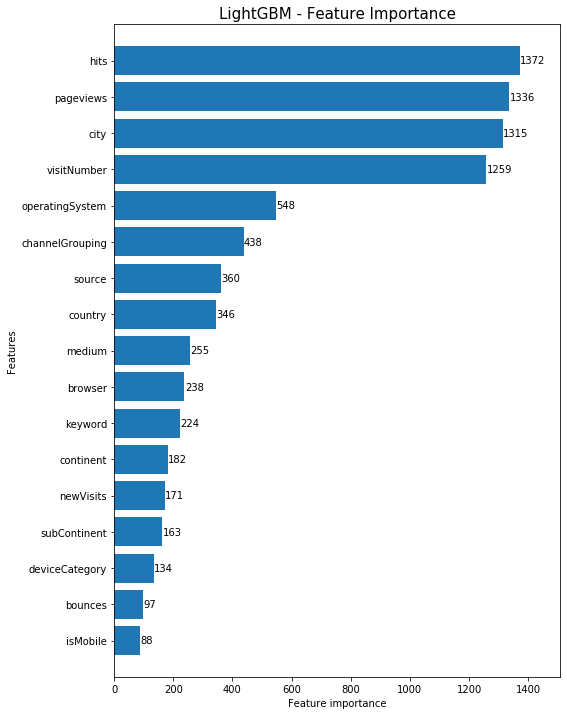

In [55]:
fig, ax = plt.subplots(figsize=(8,12))
lgbm.plot_importance(lgb_model, max_num_features=30, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [ ]:
grid= {"min_child_weight":[4,5,6],"max_depth":[-1,1,3,5], "learning_rate":[0.1,0.01,0.2]}
lgb=LGBMRegressor(random_state=96,objective='regression',metric='rmse')
gridsearch= GridSearchCV(lgb,param_grid=grid,cv=5)
gridsearch.fit(X_train, y_train)
print(gridsearch.best_score_)
print(gridsearch.best_params_)

In [56]:
lgb= LGBMRegressor(objective='regression',metric='rmse',learning_rate=0.1,min_child_weight=4)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
accuracy = lgb.score(X_test,y_test)
'Accuracy: ' + str(np.round(accuracy*100, 2)) + '%'

'Accuracy: 31.45%'

In [ ]:
mean_absolute_error(y_test, lgb_pred)

In [ ]:
mean_squared_error(y_test, lgb_pred)

In [ ]:
np.sqrt(mean_squared_error(y_test, lgb_pred))

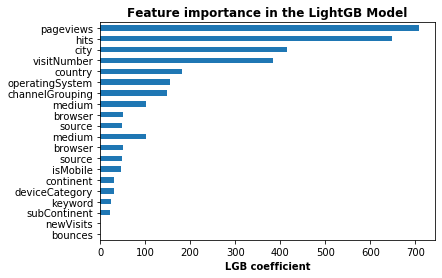

In [57]:
coefs = pd.Series(lgb.feature_importances_, index = X_train.columns)
imp_coefs = pd.concat([coefs.sort_values().head(10),coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.xlabel("LGB coefficient", weight='bold')
plt.title("Feature importance in the LightGB Model", weight='bold')
plt.show()

## Conclusion

The objective of this project was to build a model to predict how much visitors of GStore will spend. This objective was selected based on a prevailing concept in business that most amount of revenue comes from a small percentage of customers (80/20 rule). Identification of that small percentage of the customers could assist the marketing department to focus its
efforts and manage its resources more efficiently. The best performed model in this project was light gbm with fast speed, maximum accuracy and least over fitting with the Root Mean Square Error (RMSE) of 1.53. In this study we assumed that all visits are independent and not considering relationships between visitors. For example, one might explore what he wanted to buy on his smartphone but then order by using his desktop. We can group people by their visit start time, visitor id and other information, and then consider these visits as one visit. That may help to build better predicting model.

Models mostly agree on the level of the importance of the top features as follows:

• Total hits

• Total pageviews

• Number of visits

• Location of the user

• Operating System of the device

